In [1]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# LangSmith
from langsmith import traceable

# General Imports
import os
import ast
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display
from prompts import personality_scientist_prompt, extractor_prompt, recommender_prompt

# Connect to graph
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
graph = Neo4jGraph()

# Create Agent's State
class AgentState(TypedDict):
    conversation: Annotated[list[ AnyMessage ], operator.add]
    tool_messages: Annotated[list[ list[AnyMessage] ], operator.add]
    cypher_code_and_query_outputs: Annotated[list[ dict ], operator.add]
    extracted_data: Annotated[list[str], operator.add]
    query_is_unique: dict

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  
  return graph.query(query)

# Create Agent
class Agent:

    def __init__(self, model, tools, system):
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

        graph = StateGraph(AgentState) # Initialize a stateful graph
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq) # LLM node
        graph.add_node("graph_querying_tool", self.use_tool) # Use tool(query graph) called by the previous message
        graph.add_node("structure_queried_data", self.structure_queried_data)
        graph.add_node("extract_data", self.extract_data) # Extract data from last query
        graph.add_node("recommend_careers", self.recommend_careers)

        ## Create edges
        graph.add_conditional_edges("personality_scientist", self.validate_tool_call, {False: END, True: "graph_querying_tool"})

        graph.add_edge("graph_querying_tool", "structure_queried_data")
        graph.add_edge("structure_queried_data", "extract_data")
        graph.add_edge("extract_data", "recommend_careers")
        graph.add_edge("recommend_careers", END)
        graph.set_entry_point("personality_scientist")

        # Build graph
        self.graph = graph.compile(checkpointer=memory)
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    ## Get the LLM's response and update the Agent's State by adding the response to the messages
    @traceable
    def call_groq(self, state: AgentState):
        messages = state['conversation']
        
        if self.system: 
            conversation = [SystemMessage(content=self.system)] + messages
        
        ai_response = self.model.invoke(conversation)
        return {'conversation': [ai_response]}
    
    ## Check if the model called for an action by checking the last message in the conversation
    def validate_tool_call(self, state: AgentState):
        ai_message = state['conversation'][-1]
        return len(ai_message.tool_calls) > 0

    ## Search for the called tools and use it
    def use_tool(self, state: AgentState):
        
        tool_calls = state['conversation'][-1].tool_calls
        query_uniqueness_dict = {'status': True, 'index': None} # Initialize it as true and only change it if query already exists
        results = []
        
        for tool in tool_calls:
            print(f"Calling: {tool['name']}")

            ## Checking if tool not found
            if not tool['name'] in self.tools: 
                print("\n ....tool name not found in list of tools....")
                result = "tool name was not found in the list of tools, retry"  # instruct LLM to retry
            
            ## Checking if the query has already been made before
            elif tool['name'] == 'query_graph' and len(state['cypher_code_and_query_outputs']) > 0:
                print("\n ---- Tool Use Update ----> checking if query exists \n")
                # Get the previously written cypher code
                previous_queries = []
                for i in range(len(state['cypher_code_and_query_outputs'])):
                    cypher = state['cypher_code_and_query_outputs'][i]['cypher_code']
                    previous_queries.append((f"index: {i}", cypher))
                
                # Get the current cypher code written by the model
                query = tool['args']
                print(f"\n ---- Tool Use Update ----> previous queries: {previous_queries}, new_query: {query}\n")

                # Instruct the model to check if query already exists
                ai_response = self.model.invoke([
                SystemMessage(content="You are a Cypher query analyst. Your task is to detect similar queries.\
                            I will give you a new cypher query and I will give you a list of queries made of tuples containing [(index, cypher query code)]\
                            Example of the list of tuples: [(index: 0, query...)]\
                            You will analyze the new cypher query and check if it is found in the list of queries.\
                            if a similar query is found in the list, you will return the number assigned to the cypher query in the list, which is the index. if the query is not found in the list you will return 'None'.\
                            dont add any description or explanation.\
                            Summary: your output is either the index number assigned to the query or 'None'\
                            Examples: \
                            You find that the new query exists, return 'None\
                            You find that the new query does not exist in the list, return 1\
                            note that 1 is the index inside the tuple\
                            "),
                HumanMessage(content=f"new cypher query: {query}. List of queries: {previous_queries}")
                ])
                
                print(f"\n---- Tool Use Update ----> ai_response: {ai_response}\n")
                
                # If query is unique, query the graph
                if 'none' in ai_response.content.lower():
                    print(f"\n ---- Tool Use Update ----> unique query\n")
                    try:
                        result = self.tools[tool['name']].invoke(tool['args'])
                    except ValueError as e: # If written cypher code is wrong
                        result = f"ValueError occurred: {str(e)}"    

                # If query already exists, give the model the previous output of this query
                else:
                    print(f"\n ---- Tool Use Update ----> query exists\n")
                    index = int(ai_response.content)
                    result = state['cypher_code_and_query_outputs'][index]['output']
                    query_uniqueness_dict = {'status': False, 'index': index}

            
            ## If no previous queries have been made, query the graph
            else:
                print(f"\n---- Tool Use Update ----> query is unique\n")
                try:
                    result = self.tools[tool['name']].invoke(tool['args'])
                except ValueError as e: # If written cypher code is wrong
                    result = f"ValueError occurred: {str(e)}" 

            # Save the message returned from the tool
            results.append(ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result)))

        print("Back to the model!")
        return {'tool_messages': [results], 'query_is_unique': query_uniqueness_dict}
    
    ## Organize the tool's output as: {'cypher_code': Cypher code, 'output': Query output}
    def structure_queried_data(self, state: AgentState):
        
        if state['query_is_unique']['status'] == True:
            tool_calls = state['conversation'][-1].additional_kwargs['tool_calls'] # returns a list of dictionaries
            query_output = state['tool_messages'][-1] # returns a list of tool messages

            structured_outputs = []
            for i in range(len(tool_calls)):
                cypher_code = ast.literal_eval(tool_calls[i]['function']['arguments'])['query']
                output = query_output[i].content
                
                if cypher_code:
                    structured_outputs.append({'cypher_code': cypher_code, 'output': output})

            return {'cypher_code_and_query_outputs': structured_outputs}
        
        else:
            print("Query already exists, skipping structure_queried_data step")
            return
    
    ## Model extracts whatever it needs from the queried data
    def extract_data(self, state: AgentState):
        
        if state['query_is_unique']['status'] == True:
            # Prepare data to give it to the model
            # NOTE: cypher_code_and_query_outputs has individual queries with their respective outputs. Here I am looping over the last (n) number of returned tool messages and grouping together to give them to the model, because the model can call the tool multiple times and return multiple tool messages. So, I check the number of tool calls (n) and use it as the number of times to loop over the last cypher_code_and_query_outputs.
            queried_data = []
            last_tool_message = state['tool_messages'][-1]
            for i in range(-1, -len(last_tool_message)-1, -1):
                cypher_code = state['cypher_code_and_query_outputs'][i]['cypher_code']
                output = state['cypher_code_and_query_outputs'][i]['output']
                queried_data.append(f"cypher code: {cypher_code}. output: {output}")
                
            prompt = [SystemMessage(content=self.system)] + state['conversation'] + [HumanMessage(content= extractor_prompt.format(queried_data=queried_data))]
        
        else:
            existing_output_index = state['query_is_unique']['index']
            queried_data = state['cypher_code_and_query_outputs'][existing_output_index]['output']

            prompt = [SystemMessage(content=self.system)] + state['conversation'] + [HumanMessage(content= extractor_prompt.format(queried_data=queried_data))]
        
        extracted_data = self.model.invoke(prompt)
        return {"extracted_data": [extracted_data.content]}

    ## Generate final output
    def recommend_careers(self, state: AgentState):
        prompt = [SystemMessage(content=self.system)] + state['conversation']
        prompt = prompt + [HumanMessage(content= recommender_prompt.format(extracted_data=state['extracted_data'][-1]))]
        
        recommended_careers = self.model.invoke(prompt)
        return {'conversation': [recommended_careers]}

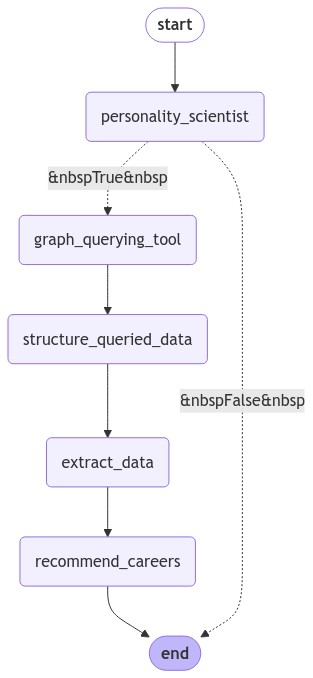

In [2]:
model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
# model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")

agent = Agent(model=model, tools=[query_graph], system=personality_scientist_prompt.format(schema=graph.structured_schema))

In [ ]:
thread = {'configurable': {'thread_id': "1"}}
output = agent.graph.stream({"conversation": [HumanMessage(content="plan out your activities and stick to a schedule")]}, thread, stream_mode='values')

for message in output:
    message['conversation'][-1].pretty_print()

In [ ]:
state = agent.graph.get_state(thread).values


len(state['tool_messages'][-1]), len(state['cypher_code_and_query_outputs'])

# state['conversation']
state['cypher_code_and_query_outputs']
# state['extracted_data']
# state['tool_messages']
# state['query_is_unique']
state

In [ ]:
def extract_labels_from_query(cypher_code):
  # Extract start index and end index of the labels example: (n:Occupation) => start is ( end is )
  start = []
  end = []
  for i, character in enumerate(cypher_code):
    if character == "(": start.append(i+1)
    if character == ")": end.append(i)

  # Extract the labels using the start and end indicies. return labels as {'n': 'Occupation'...}
  labels = {}
  for i in range(len(start)):
    label = cypher_code[start[i]: end[i]] # returns "n:Occupation"
    label = label.split(":") # returns ["n", "Occupation"]

    labels[label[0]] = label[1]

  return labels


def organize_queried_data(data, labels):
  structured_queried_data = {'labels': list(labels.values()), 'relations': []}

  for i in range(len(data)):
    # extract keys (nodes' refrences as they were returned from the query's output. example: "cypher code ... return n,m")
    row = data[i]
    keys = list(row.keys()) # keys are the referenced labels. example: n:Occupation, so n is referencing Occupation
    
    # Extract node relations. example: Occupation: Teacher, Personality_Trait: Social
    
    relation = []
    for i in range(len(keys)):
      key = keys[i]
      # label = labels[key]
      properties = row[key]
      
      relation.append(properties)

    structured_queried_data['relations'] += [relation]
  
  return structured_queried_data

query_output = ast.literal_eval(state['cypher_code_and_query_outputs'][0]['output'])
llm_query = state['cypher_code_and_query_outputs'][0]['cypher_code']

labels = extract_labels_from_query(cypher_code=llm_query)
outputs = organize_queried_data(data=query_output, labels=labels)
outputs